# **Introduction to the Cart Pole Problem**

# Table of Contents




- [Introduction to the Cart Pole Problem](#introduction-to-the-cart-pole-problem)
- [Setup](#Setup)
- [DQN](#dqn)
  - [Implementing DQN components](#implementing-dqn-components)
    - [Replay Memory Class](#replay-memory-class)
    - [DQN Network Class](#dqn-network-class)
    - [DQN Agent Class](#dqn-agent-class)
  - [Model_TrainTest Class](#model-traintest-class)
    - [State Preprocessing](#state-preprocessing)
    - [Training](#training)
    - [Testing](#testing)
    - [Visualization](#visualization)

## **Overview**


This project focuses on applying and comparing two popular reinforcement learning algorithms, Deep Q-Network (DQN) and State-Action-Reward-State-Action (SARSA), to solve the classic "Cart Pole" problem. This problem is a fundamental test in the field of reinforcement learning, where the objective is to balance a pole, hinged to a cart, by moving the cart left or right.

### Objectives

The main goals of this project are to:


*   implement the DQN and SARSA algorithms using PyTorch.
*   train these models to balance the pole on the moving cart as long as possible.
*   evaluate and compare the performance of these algorithms in terms of learning efficiency and stability.

#**Setup**

### **Running the Notebook**

This notebook is designed to run in Google Colab. It requires no additional setup from the user's local environment except access to the internet and a Google account.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installation of Required Libraries

Before we start implementing the algorithms, we need to ensure that all necessary libraries are installed. Run the following cells to install the required packages.

In [3]:
!pip install gymnasium
!pip install torch
!pip install renderlab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

### Importing Libraries

Now, let's import the necessary libraries that we will use throughout this project.

In [4]:
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
import renderlab
import pygame
import matplotlib.image as mpimg


### Setting Up GPU and Reproducibility

This section initializes the environment and sets up the GPU (if available) for computation. It also ensures reproducibility by setting random seeds.

In [5]:
print(f"torch.cuda: {torch.cuda.is_available()}" )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.cuda: False
Using device: cpu


In [6]:
# Clear memory and set random seeds for reproducibility
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Immediate CUDA error reporting
seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# **Boltzmann Exploration in DQN Agents**



## **Implementing**

In this implementation, we replace the traditional epsilon-greedy exploration strategy with Boltzmann exploration in Deep Q-Network (DQN) agents. Boltzmann exploration, also known as softmax action selection, is a probabilistic method for selecting actions based on their estimated values. Unlike epsilon-greedy, which selects actions either greedily or randomly, Boltzmann exploration assigns probabilities to actions according to their Q-values and a temperature parameter.

#### Changes Made:
1. **Initialization**:
   - Removed epsilon-related parameters (`epsilon_max`, `epsilon_min`, `epsilon_decay`).
   - Introduced temperature-related parameters (`temperature_max`, `temperature_min`, `temperature_decay`).
   
2. **Action Selection**:
   - Modified the `select_action` method in the `DQN_Agent` class to compute action probabilities using the Boltzmann distribution.
   - Sampled actions from the action space based on the computed probabilities.
   
3. **Temperature Decay**:
   - Implemented a mechanism to decay the temperature over time, controlling the exploration-exploitation trade-off.
   - Updated the temperature parameter at the end of each episode or after a certain number of steps.

In [7]:
ls

drive/  sample_data/


In [15]:
cd drive/MyDrive/DRL/cartpole/Boltzmann


/content/drive/.shortcut-targets-by-id/1SGODVxr2QsHrO1H5QuGtjHsUuw3_9yWj/Boltzmann


In [16]:
class ReplayMemory:
    def __init__(self, capacity):
        # Initialize replay memory with a specified capacity
        self.capacity = capacity
        self.states = deque(maxlen=capacity)
        self.actions = deque(maxlen=capacity)
        self.next_states = deque(maxlen=capacity)
        self.rewards = deque(maxlen=capacity)
        self.dones = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        # Store an experience (state, action, next_state, reward, done) in the replay memory
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)

    def sample(self, batch_size):
        # Sample a batch of experiences from the replay memory
        indices = np.random.choice(len(self), size=batch_size, replace=False)
        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices])
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device) for i in indices])
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32, device=device)
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)
        return states, actions, next_states, rewards, dones

    def __len__(self):
        # Return the current size of the replay memory
        return len(self.dones)


In [17]:
class DQN_Network(nn.Module):
    def __init__(self, num_actions, input_dim):

        super(DQN_Network, self).__init__()

        # Define the neural network layers
        self.FC = nn.Sequential(
            nn.Linear(input_dim, 512),  # Input layer to first hidden layer with 512 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(512, 256),       # Second hidden layer with 256 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(256, 64),        # Third hidden layer with 64 nodes
            nn.ReLU(),                 # ReLU activation for non-linearity
            nn.Linear(64, num_actions) # Output layer with 'num_actions' nodes
        )

        # Initialize weights using He initialization (also known as Kaiming initialization)
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.FC(x)


In [18]:
class DQN_Agent:
    def __init__(self, env, temperature_max, temperature_min, temperature_decay,
                 clip_grad_norm, learning_rate, discount, memory_capacity):

        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

        # RL hyperparameters
        self.temperature_max = temperature_max
        self.temperature_min = temperature_min
        self.temperature_decay = temperature_decay
        self.temperature = self.temperature_max

        self.discount = discount

        self.state_size = env.observation_space.shape[0]
        self.action_space = env.action_space
        self.action_space.seed(seed)  # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)

        # Initiate the network models
        self.main_network = DQN_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device)
        self.target_network = DQN_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm  # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)

    def select_action(self, state):
        """
        Select an action using Boltzmann exploration.
        """
        action_probs = self.get_action_probs(state)
        action = np.random.choice(len(action_probs), p=action_probs)
        return action

    def get_action_probs(self, state):
        """
        Get action probabilities using Boltzmann distribution.
        """
        with torch.no_grad():
            Q_values = self.main_network(state)
            action_values = Q_values / self.temperature
            action_probs = torch.softmax(action_values, dim=-1).cpu().numpy()
        return action_probs


    def learn(self, batch_size, done):
        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)

        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)

        predicted_q = self.main_network(
            states)  # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(dim=1,
                                         index=actions)

        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[
                0]

        next_target_q_value[dones] = 0  # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value)  # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js)
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = self.running_loss / self.learned_counts  # The average loss for the episode
            self.loss_history.append(episode_loss)  # Append the episode loss to the loss history for plotting
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Perform backward pass and update the gradients

        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)

        self.optimizer.step()  # Update the parameters of the main network using the optimizer

    def hard_update(self):
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_temperature(self):
        """
        Decay temperature.
        """
        self.temperature = max(self.temperature * self.temperature_decay, self.temperature_min)


    def save(self, path):
        torch.save(self.main_network.state_dict(), path)


In [19]:
class Model_TrainTest:
    def __init__(self, hyperparams):

        # Define RL Hyperparameters
        self.train_mode = hyperparams["train_mode"]
        self.RL_load_path = hyperparams["RL_load_path"]
        self.save_path = hyperparams["save_path"]
        self.save_interval = hyperparams["save_interval"]
        self.report = hyperparams["report"]
        self.early_stop_threshold = hyperparams["early_stop_threshold"]
        self.early_stop_window = hyperparams["early_stop_window"]
        self.render_output_path = hyperparams["render_output_path"]
        self.clip_grad_norm = hyperparams["clip_grad_norm"]
        self.learning_rate = hyperparams["learning_rate"]
        self.discount_factor = hyperparams["discount_factor"]
        self.batch_size = hyperparams["batch_size"]
        self.update_frequency = hyperparams["update_frequency"]
        self.max_episodes = hyperparams["max_episodes"]
        self.max_steps = hyperparams["max_steps"]
        self.render = hyperparams["render"]

        ### changes
        self.temperature_max = hyperparams["temperature_max"]
        self.temperature_min = hyperparams["temperature_min"]
        self.temperature_decay = hyperparams["temperature_decay"]
        ###

        self.memory_capacity = hyperparams["memory_capacity"]
        self.num_states = hyperparams["num_states"]
        self.map_size = hyperparams["map_size"]
        self.render_fps = hyperparams["render_fps"]
        self.env = gym.make('CartPole-v1',
                            render_mode="rgb_array" if self.render else None)
        self.env.metadata['render_fps'] = self.render_fps  # For max frame rate make it 0
        self.agent = DQN_Agent(
                          env=self.env,
                          temperature_max=self.temperature_max,
                          temperature_min=self.temperature_min,
                          temperature_decay=self.temperature_decay,
                          clip_grad_norm=self.clip_grad_norm,
                          learning_rate=self.learning_rate,
                          discount=self.discount_factor,
                          memory_capacity=self.memory_capacity
                      )

    def state_preprocess(self, state: int, num_states: int):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        return state

    def train(self):

        total_steps = 0
        self.reward_history = []
        self.temperature_history = []
        consecutive_rewards = 0

        # Training loop over episodes
        for episode in range(1, self.max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)
                angle = next_state[2]  # Assuming next_state[2] is the pole angle
                angle_reward = 1.0 - abs(angle) / np.pi  # Normalize and invert the angle to get reward
                reward += angle_reward  # Modify reward with additional reward shaping

                x_pos = abs(next_state[0])
                if x_pos > 4:
                    reward -= x_pos
                elif x_pos > 2:
                    reward -= x_pos * 0.5

                if (reward > 0):
                        reward /= 2
                self.agent.replay_memory.store(state, action, next_state, reward, done)

                if len(self.agent.replay_memory) > self.batch_size and sum(self.reward_history) > 0:
                    self.agent.learn(self.batch_size, (done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.hard_update()

                state = next_state
                episode_reward += reward
                step_size += 1

            # Appends for tracking history
            self.reward_history.append(episode_reward)  # episode reward
            self.temperature_history.append(self.agent.temperature)
            total_steps += step_size

            if episode_reward >= self.early_stop_threshold:
                consecutive_rewards += 1
            else:
                consecutive_rewards = 0

             # Check for early stopping condition
            if consecutive_rewards >= self.early_stop_window:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Temperature: {self.agent.temperature:.2f}")
                print(result)
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                print(f"Early stopping at episode {episode} as reward exceeded threshold for {self.early_stop_window} consecutive episodes.")

                break
            # Decay Temperature at the end of each episode
            self.agent.update_temperature()

            # -- based on interval
            if episode % self.save_interval == 0 or episode == self.max_episodes or episode == 10:
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                # if episode != self.max_episodes:
                    # self.plot_training(episode)
                print('\n~~~~~~Interval Save: Model saved.\n')

            if episode % self.report == 0:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Temperature: {self.agent.temperature:.2f}")
                print(result)
        self.plot_training(episode)

    def test(self, max_episodes):
        """
        Reinforcement learning policy evaluation.
        """
        env = renderlab.RenderFrame(self.env, self.render_output_path)
        # Load the weights of the test_network
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path, map_location=torch.device('cpu')))
        self.agent.main_network.eval()

        # Testing loop over episodes
        for episode in range(1, max_episodes + 1):
            state, _ = env.reset(seed=seed)
            # state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                state = self.state_preprocess(state, num_states=self.num_states)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = env.step(action)
                # next_state, reward, done, truncation, _ = self.env.step(action)

                state = next_state
                episode_reward += reward
                step_size += 1

            # Print log
            result = (f"total Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f} ")
            print(result)


        env.play()
        pygame.quit()  # close the rendering window

    def plot_training(self, episode):
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50) / 50, mode='valid')

        # Plot Rewards
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Loss_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        # Plot Tempreture
        plt.figure()
        plt.title("Temperature")
        plt.plot(np.arange(1, episode + 1), self.temperature_history, color='g')
        plt.xlabel("Episode")
        plt.ylabel("Temperature")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Temperature_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()


In [20]:
def handler(train_mode=True, RL_hyperparameters = {}):
    # Initialize and run the model
    DRL = Model_TrainTest(RL_hyperparameters)
    if train_mode:
        DRL.train()
    else:
        DRL.test(max_episodes=RL_hyperparameters['max_episodes'])

In [21]:
def set_hyperparameters(train_mode):
    render = not train_mode
    RL_hyperparams = {
        "train_mode": train_mode,
        "RL_load_path": f'./final_weights_{"1000"}.pth',
        "save_path": f'./final_weights',
        "early_stop_threshold": 496,
        "early_stop_window": 30,
        "save_interval": 500,
        "report": 10,
        "clip_grad_norm": 3,
        "learning_rate": 6e-4,
        "discount_factor": 0.93,
        "batch_size": 32,
        "update_frequency": 10,
        "max_episodes": 1000 if train_mode else 1,
        "max_steps": 200,
        "render": render,
        "temperature_max": 10 if train_mode else 0.001,
        "temperature_min": 0.0001,
        "temperature_decay": 0.995,
        "memory_capacity": 4_000 if train_mode else 0,
        "map_size": 8,
        "num_states": 8 ** 2,
        "render_fps": 30,
    }
    return RL_hyperparams

## **train and comparing with different temperatures**

#### Hyperparameter Sets for Comparison:
1. **Set 1**:
   - `temperature_max`: 1000
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

2. **Set 2**:
   - `temperature_max`: 10
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

3. **Set 3**:
   - `temperature_max`: 0.1
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

4. **Set 4 (constant temperature)**:
   - `temperature_max`: 1
   - `temperature_min`: 0.0001
   - `temperature_decay`: 1

In [22]:
hyperparams_sets = [
        {"temperature_max": 1000, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 10, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 0.1, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 1, "temperature_min": 0.0001, "temperature_decay": 1}
    ]

In [ ]:
def main():
    # Hyperparameter Sets for Comparison
    hyperparams_sets = [
        {"temperature_max": 1000, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 10, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 0.1, "temperature_min": 0.0001, "temperature_decay": 0.995},
        {"temperature_max": 1, "temperature_min": 0.0001, "temperature_decay": 1}
    ]

    # Create a folder for each hyperparameter set and run training and testing
    for idx, hyperparams in enumerate(hyperparams_sets):
        folder_name = f"Hyperparams_Set_{idx + 1}"
        os.makedirs(folder_name, exist_ok=True)
        os.chdir(folder_name)

        print(f"Training with Hyperparameter Set {idx + 1}")
        print(hyperparams)
        RL_hyperparams = set_hyperparameters(train_mode=True)
        RL_hyperparams["temperature_max"] = hyperparams["temperature_max"]
        RL_hyperparams["temperature_min"] = hyperparams["temperature_min"]
        RL_hyperparams["temperature_decay"] = hyperparams["temperature_decay"]

        handler(train_mode=True, RL_hyperparameters=RL_hyperparams)

        # Move back to the main directory
        os.chdir("..")

if __name__ == "__main__":
    main()


Training with Hyperparameter Set 1
{'temperature_max': 1000, 'temperature_min': 0.0001, 'temperature_decay': 0.995}

~~~~~~Interval Save: Model saved.

Episode: 10, Total Steps: 215, Ep Step: 15, Raw Reward: 14.78, Temperature: 951.11
Episode: 20, Total Steps: 440, Ep Step: 11, Raw Reward: 10.82, Temperature: 904.61
Episode: 30, Total Steps: 652, Ep Step: 13, Raw Reward: 12.84, Temperature: 860.38
Episode: 40, Total Steps: 911, Ep Step: 16, Raw Reward: 15.78, Temperature: 818.32
Episode: 50, Total Steps: 1172, Ep Step: 19, Raw Reward: 18.79, Temperature: 778.31
Episode: 60, Total Steps: 1484, Ep Step: 49, Raw Reward: 48.64, Temperature: 740.26
Episode: 70, Total Steps: 1704, Ep Step: 18, Raw Reward: 17.75, Temperature: 704.07
Episode: 80, Total Steps: 1926, Ep Step: 14, Raw Reward: 13.80, Temperature: 669.65
Episode: 90, Total Steps: 2177, Ep Step: 31, Raw Reward: 30.77, Temperature: 636.91
Episode: 100, Total Steps: 2381, Ep Step: 16, Raw Reward: 15.77, Temperature: 605.77
Episode: 11

In [23]:
def load_and_display_figures_temperature(main_title, temperature_path, loss_path, reward_path):
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Load and display temperature plot
    temperature_img = mpimg.imread(temperature_path)
    axs[0].imshow(temperature_img)
    axs[0].axis('off')
    axs[0].set_title('temperature Plot')

    # Load and display Loss plot
    loss_img = mpimg.imread(loss_path)
    axs[1].imshow(loss_img)
    axs[1].axis('off')
    axs[1].set_title('Loss Plot')

    # Load and display Reward plot
    reward_img = mpimg.imread(reward_path)
    axs[2].imshow(reward_img)
    axs[2].axis('off')
    axs[2].set_title('Reward Plot')

    # Add main title
    fig.suptitle(main_title, fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()

### **Set 1**:

   - `temperature_max`: 1000
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

In [ ]:
cd Hyperparams_Set_1

/content/drive/MyDrive/DRL/cartpole/Boltzmann/Hyperparams_Set_1


In [ ]:
ls

final_weights_1000.pth  final_weights_500.pth  reward_plot.png
final_weights_10.pth    Loss_plot.png          Temperature_plot.png


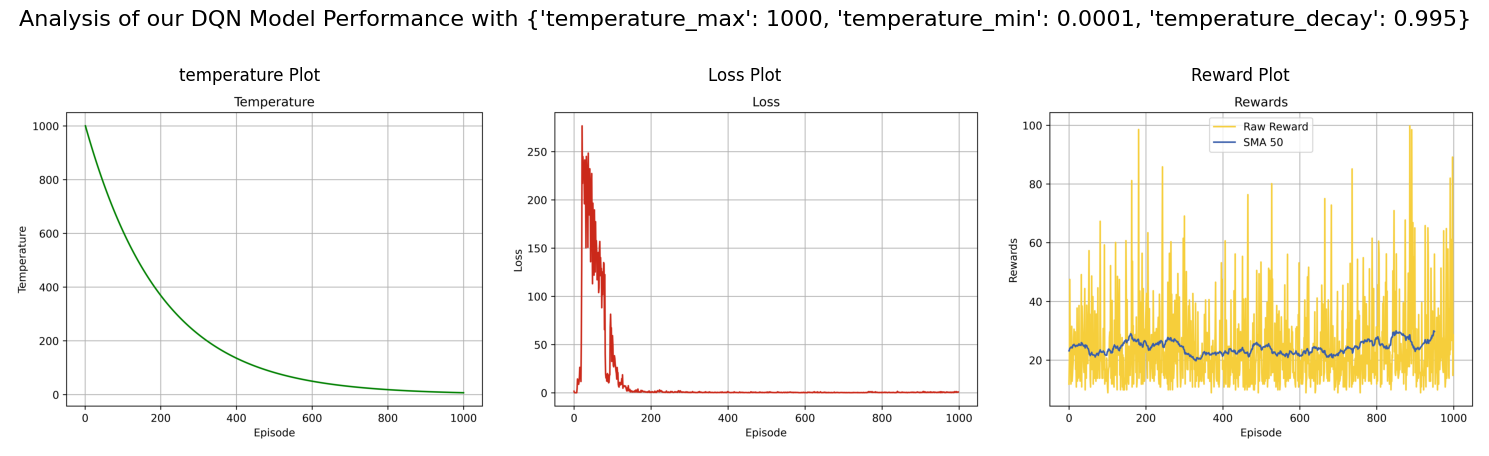

In [ ]:
# Example usage
main_title = f"Analysis of our DQN Model Performance with {hyperparams_sets[0]}"
temperature_path = "Temperature_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"

load_and_display_figures_temperature(main_title, temperature_path, loss_path, reward_path)

In [ ]:
cd ..

/content/drive/MyDrive/DRL/cartpole/Boltzmann


### **Set 2**:

   - `temperature_max`: 10
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

In [ ]:
cd Hyperparams_Set_2

/content/drive/MyDrive/DRL/cartpole/Boltzmann/Hyperparams_Set_2


In [ ]:
ls

final_weights_1000.pth  final_weights_500.pth  reward_plot.png
final_weights_10.pth    Loss_plot.png          Temperature_plot.png


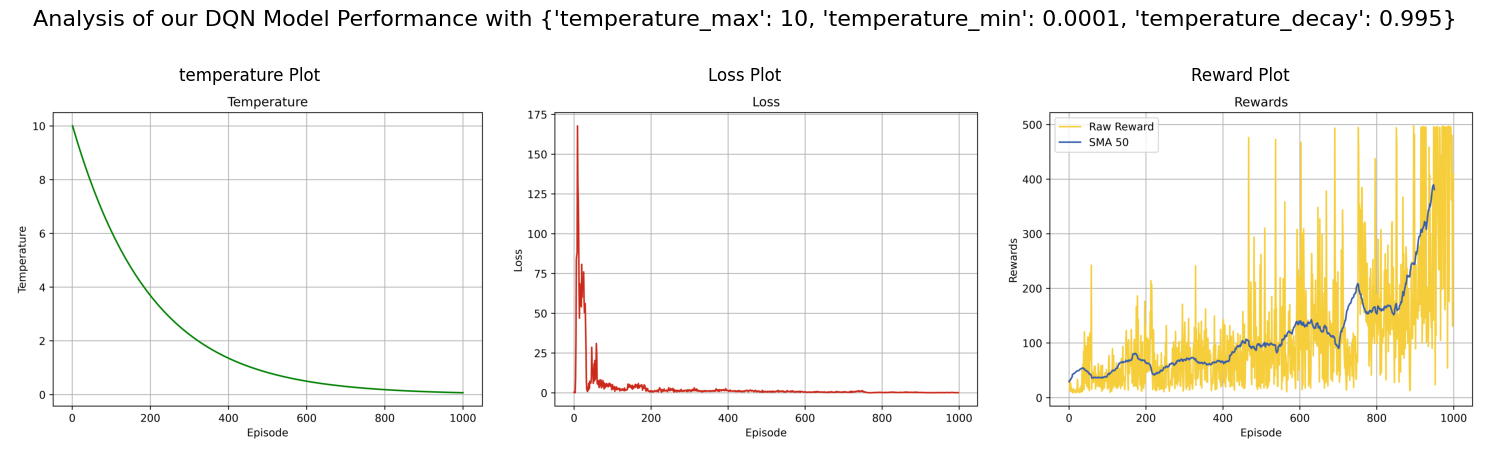

In [ ]:
# Example usage
main_title = f"Analysis of our DQN Model Performance with {hyperparams_sets[1]}"
temperature_path = "Temperature_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"

load_and_display_figures_temperature(main_title, temperature_path, loss_path, reward_path)

In [ ]:
cd ..

/content/drive/MyDrive/DRL/cartpole/Boltzmann


### **Set 3**:

   - `temperature_max`: 0.1
   - `temperature_min`: 0.0001
   - `temperature_decay`: 0.9995

In [ ]:
cd Hyperparams_Set_3

/content/drive/MyDrive/DRL/cartpole/Boltzmann/Hyperparams_Set_3


In [ ]:
ls

final_weights_1000.pth  final_weights_500.pth  reward_plot.png
final_weights_10.pth    Loss_plot.png          Temperature_plot.png


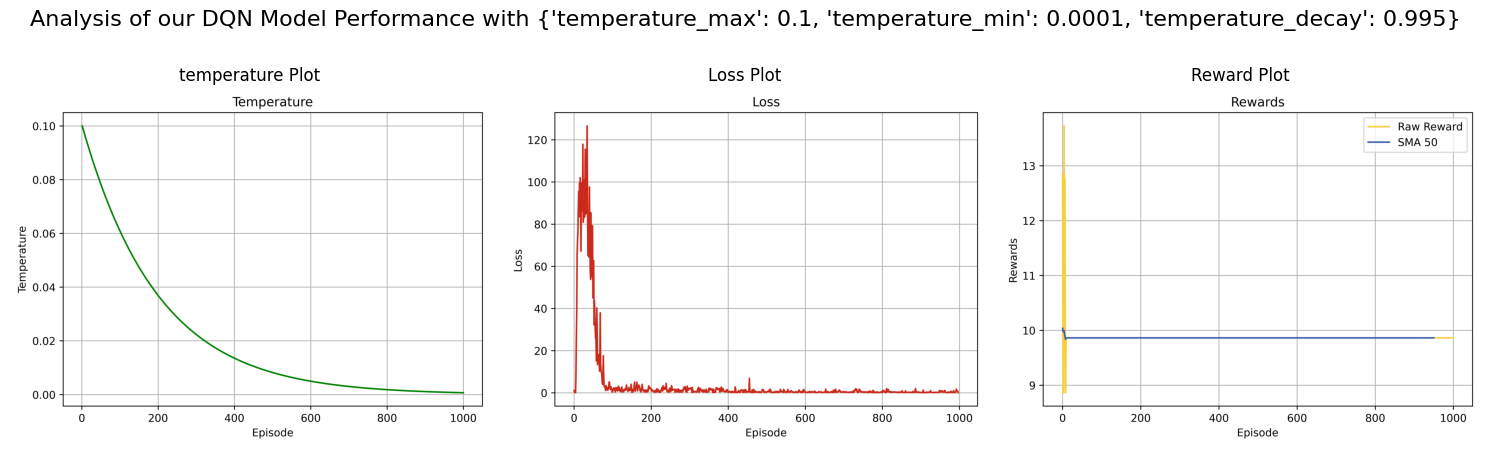

In [ ]:
# Example usage
main_title = f"Analysis of our DQN Model Performance with {hyperparams_sets[2]}"
temperature_path = "Temperature_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"

load_and_display_figures_temperature(main_title, temperature_path, loss_path, reward_path)

In [ ]:
cd ..

/content/drive/MyDrive/DRL/cartpole/Boltzmann


### **Set 4**:

   - `temperature_max`: 1
   - `temperature_min`: 0.0001
   - `temperature_decay`: 1

In [ ]:
cd Hyperparams_Set_4

/content/drive/MyDrive/DRL/cartpole/Boltzmann/Hyperparams_Set_4


In [ ]:
ls

final_weights_1000.pth  final_weights_500.pth  reward_plot.png
final_weights_10.pth    Loss_plot.png          Temperature_plot.png


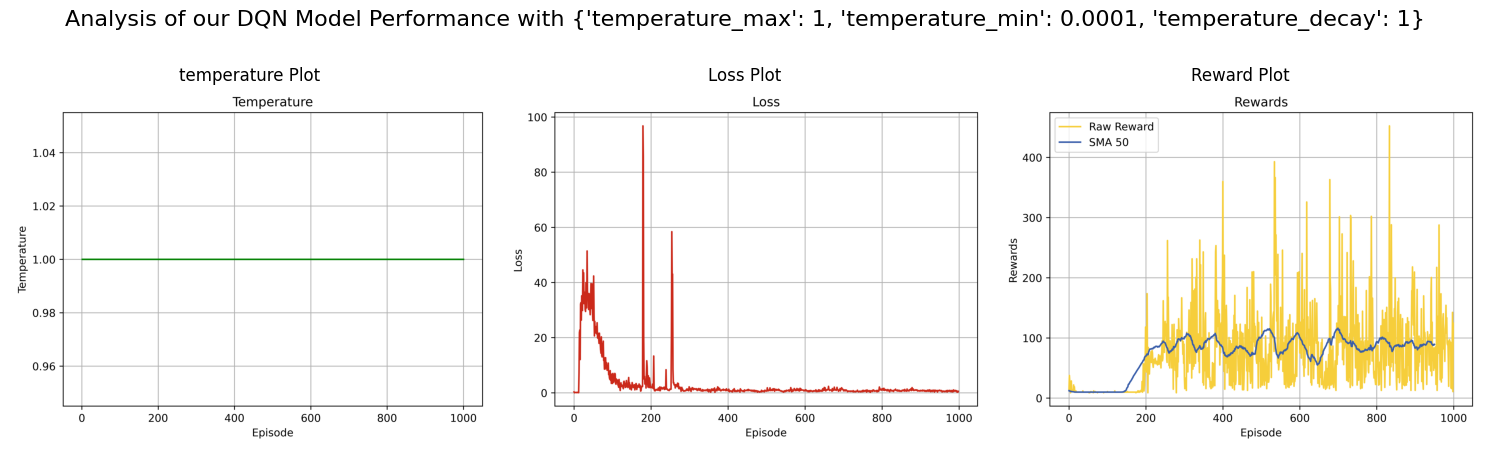

In [ ]:
# Example usage
main_title = f"Analysis of our DQN Model Performance with {hyperparams_sets[3]}"
temperature_path = "Temperature_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"

load_and_display_figures_temperature(main_title, temperature_path, loss_path, reward_path)